### Above was the code for simple rag pipeline

In [20]:
%env GOOGLE_API_KEY=your_api_key

env: GOOGLE_API_KEY=your_api_key


In [2]:
import pprint
import sqlite3
import json
import uuid
from datetime import datetime
from typing import Dict, List, Optional, Any, TypedDict, Annotated
from dataclasses import dataclass, field
from enum import Enum

# LangChain imports
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_qdrant import QdrantVectorStore
from langchain_core.prompts import ChatPromptTemplate
from langchain.output_parsers import OutputFixingParser, PydanticOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain.chains import RetrievalQA

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver

from langchain_community.storage import SQLStore

In [3]:
@dataclass
class CaseState:
    case_id: str
    company_name: str
    industry: str
    geography: str
    case_type: str  # profitability, market_entry, new_product, etc.
    hypothesis_tree: Dict[str, Any] = field(default_factory=dict)
    current_question: str = ""
    expected_frameworks: List[str] = field(default_factory=list)
    user_approach: List[str] = field(default_factory=list)
    created_at: datetime = field(default_factory=datetime.now)

@dataclass
class UserProgress:
    session_id: str
    current_step: int = 1
    frameworks_attempted: List[str] = field(default_factory=list)
    mistakes_made: List[Dict] = field(default_factory=list)
    hints_used: int = 0
    performance_score: float = 0.0
    time_spent: int = 0  # in minutes

@dataclass
class FeedbackLog:
    feedback_id: str
    session_id: str
    question: str
    user_response: str
    bot_feedback: str
    improvement_areas: List[str] = field(default_factory=list)
    timestamp: datetime = field(default_factory=datetime.now)

class CaseDifficulty(Enum):
    BEGINNER = "beginner"
    INTERMEDIATE = "intermediate"
    ADVANCED = "advanced"


In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    session_id: str
    case_state: Optional[CaseState]
    user_progress: Optional[UserProgress]
    current_context: str
    retrieval_context: str


In [5]:
import sqlite3
import json
from datetime import datetime
from typing import Optional, Dict, Any

# Custom datetime adapter and converter functions
def adapt_datetime(dt):
    """Convert datetime to ISO format string for SQLite"""
    return dt.isoformat()

def convert_datetime(s):
    """Convert ISO format string back to datetime"""
    return datetime.fromisoformat(s.decode())

# Register the custom adapter and converter
sqlite3.register_adapter(datetime, adapt_datetime)
sqlite3.register_converter('timestamp', convert_datetime)

class StateManager:
    def __init__(self, db_path: str = "case_state.db"):
        self.db_path = db_path
        
        self.store = SQLStore(db_url=f"sqlite:///{db_path}", namespace="statemanager")
        self._init_tables()
    
    def _get_connection(self):
        return sqlite3.connect(self.db_path, detect_types=sqlite3.PARSE_DECLTYPES)
    
    def _init_tables(self):
        conn = self._get_connection()
        cursor = conn.cursor()
        
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS case_states (
                case_id TEXT PRIMARY KEY,
                session_id TEXT,
                company_name TEXT,
                industry TEXT,
                geography TEXT,
                case_type TEXT,
                hypothesis_tree TEXT,
                current_question TEXT,
                expected_frameworks TEXT,
                user_approach TEXT,
                created_at timestamp,
                updated_at timestamp
            )
        ''')
        
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS user_progress (
                session_id TEXT PRIMARY KEY,
                current_step INTEGER,
                frameworks_attempted TEXT,
                mistakes_made TEXT,
                hints_used INTEGER,
                performance_score REAL,
                time_spent INTEGER,
                last_updated timestamp
            )
        ''')
        
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS feedback_logs (
                feedback_id TEXT PRIMARY KEY,
                session_id TEXT,
                question TEXT,
                user_response TEXT,
                bot_feedback TEXT,
                improvement_areas TEXT,
                timestamp timestamp
            )
        ''')
        
        conn.commit()
        conn.close()
    
    def save_case_state(self, case_state: CaseState, session_id: str) -> None:
        conn = self._get_connection()
        cursor = conn.cursor()
        
        cursor.execute('''
            INSERT OR REPLACE INTO case_states 
            (case_id, session_id, company_name, industry, geography, case_type,
             hypothesis_tree, current_question, expected_frameworks, user_approach,
             created_at, updated_at)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            case_state.case_id, session_id, case_state.company_name,
            case_state.industry, case_state.geography, case_state.case_type,
            json.dumps(case_state.hypothesis_tree), case_state.current_question,
            json.dumps(case_state.expected_frameworks), json.dumps(case_state.user_approach),
            case_state.created_at, datetime.now()
        ))
        
        conn.commit()
        conn.close()
    
    def load_case_state(self, session_id: str) -> Optional[CaseState]:
        conn = self._get_connection()
        cursor = conn.cursor()
        
        cursor.execute('SELECT * FROM case_states WHERE session_id = ? ORDER BY updated_at DESC LIMIT 1', (session_id,))
        row = cursor.fetchone()
        conn.close()
        
        if row:
            return CaseState(
                case_id=row[0],
                company_name=row[2],
                industry=row[3],
                geography=row[4],
                case_type=row[5],
                hypothesis_tree=json.loads(row[6]),
                current_question=row[7],
                expected_frameworks=json.loads(row[8]),
                user_approach=json.loads(row[9]),
                created_at=row[10]  # Now properly converted back to datetime
            )
        return None
    
    def save_user_progress(self, progress: UserProgress) -> None:
        """Save user progress to database"""
        conn = self._get_connection()
        cursor = conn.cursor()
        
        cursor.execute('''
            INSERT OR REPLACE INTO user_progress 
            (session_id, current_step, frameworks_attempted, mistakes_made,
             hints_used, performance_score, time_spent, last_updated)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            progress.session_id, progress.current_step,
            json.dumps(progress.frameworks_attempted), json.dumps(progress.mistakes_made),
            progress.hints_used, progress.performance_score, progress.time_spent,
            datetime.now()
        ))
        
        conn.commit()
        conn.close()
    
    def load_user_progress(self, session_id: str) -> Optional[UserProgress]:
        """Load user progress from database"""
        conn = self._get_connection()
        cursor = conn.cursor()
        
        cursor.execute('SELECT * FROM user_progress WHERE session_id = ?', (session_id,))
        row = cursor.fetchone()
        conn.close()
        
        if row:
            return UserProgress(
                session_id=row[0],
                current_step=row[1],
                frameworks_attempted=json.loads(row[2]),
                mistakes_made=json.loads(row[3]),
                hints_used=row[4],
                performance_score=row[5],
                time_spent=row[6]
            )
        return None
    
    def save_feedback_log(self, feedback: FeedbackLog) -> None:
        """Save feedback log to database"""
        conn = self._get_connection()
        cursor = conn.cursor()
        
        cursor.execute('''
            INSERT INTO feedback_logs 
            (feedback_id, session_id, question, user_response, bot_feedback,
             improvement_areas, timestamp)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        ''', (
            feedback.feedback_id, feedback.session_id, feedback.question,
            feedback.user_response, feedback.bot_feedback,
            json.dumps(feedback.improvement_areas), feedback.timestamp
        ))
        
        conn.commit()
        conn.close()


In [6]:
llm = ChatGoogleGenerativeAI(
    model='gemini-2.0-flash', 
    temperature=0.2
)


In [7]:
loader = PyPDFLoader('Case Compendium.pdf')
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(docs)

print(f"Loaded {len(docs)} documents")
print(f"Split into {len(texts)} chunks")


Loaded 206 documents
Split into 459 chunks


In [9]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

url = "http://localhost:6333"
vectorstore = QdrantVectorStore.from_documents(
    texts,
    embeddings,
    url=url,
    prefer_grpc=False,
    collection_name="case_interview_bot"
)

print("Vector store created successfully")


Vector store created successfully


In [11]:
state_manager = StateManager()

session_id = str(uuid.uuid4())
print(f"Session ID: {session_id}")

user_progress = state_manager.load_user_progress(session_id)
if not user_progress:
    user_progress = UserProgress(session_id=session_id)
    state_manager.save_user_progress(user_progress)
    print("New user progress initialized")
else:
    print("Loaded existing user progress")


Session ID: 0cdefeeb-3ce5-4ef5-94b2-2bbbbac45305
New user progress initialized


In [12]:
def chatbot(state: State) -> State:
    """Enhanced chatbot with case state management"""
    global state_manager, session_id, vectorstore
    
    user_message = state["messages"][-1].content
    
    case_state = state_manager.load_case_state(session_id)
    
    context_prompt = ""
    if case_state:
        context_prompt = f"""
        Current Case Context:
        - Company: {case_state.company_name}
        - Industry: {case_state.industry}
        - Case Type: {case_state.case_type}
        - Current Question: {case_state.current_question}
        - Expected Frameworks: {', '.join(case_state.expected_frameworks)}
        - User's Approach So Far: {', '.join(case_state.user_approach)}
        
        """
    
    docs = vectorstore.similarity_search(user_message, k=5)
    context = "\n\n".join([doc.page_content for doc in docs])
    
    prompt = f"""
    {context_prompt}
    
    Retrieved Context from Case Compendium:
    {context}
    
    User Question: {user_message}
    
    As a case interview coach, provide guidance based on the current case context and retrieved information.
    If this is a new case, help structure the approach using proper frameworks like MECE, profitability trees, etc.
    If continuing an existing case, provide feedback on the user's progress and suggest next steps.
    
    Be supportive, educational, and guide the user through structured problem-solving.
    """
    
    response = llm.invoke([HumanMessage(content=prompt)])
    
    feedback_log = FeedbackLog(
        feedback_id=str(uuid.uuid4()),
        session_id=session_id,
        question=user_message,
        user_response="",  # Will be updated later
        bot_feedback=response.content,
        improvement_areas=[]  # Will be analyzed later
    )
    state_manager.save_feedback_log(feedback_log)
    
    new_state = {
        "messages": state["messages"] + [AIMessage(content=response.content)],
        "session_id": session_id,
        "case_state": case_state,
        "user_progress": state_manager.load_user_progress(session_id),
        "current_context": context_prompt,
        "retrieval_context": context
    }
    
    return new_state


In [13]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

memory = InMemorySaver()

graph = graph_builder.compile(checkpointer=memory)

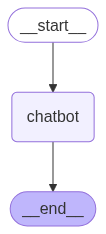

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

In [15]:
def create_new_case(company_name: str, industry: str, geography: str, case_type: str) -> CaseState:
    case_id = str(uuid.uuid4())
    case_state = CaseState(
        case_id=case_id,
        company_name=company_name,
        industry=industry,
        geography=geography,
        case_type=case_type,
        expected_frameworks=get_expected_frameworks(case_type)
    )
    return case_state

def get_expected_frameworks(case_type: str) -> List[str]:
    """Get expected frameworks based on case type"""
    framework_mapping = {
        "profitability": ["MECE", "Profitability Tree", "Cost-Revenue Analysis"],
        "market_entry": ["MECE", "Market Analysis", "Competitive Analysis", "Go-to-Market Strategy"],
        "new_product": ["MECE", "Product Development", "Market Sizing", "Business Case"],
        "operational": ["MECE", "Process Analysis", "Root Cause Analysis", "Implementation Planning"]
    }
    return framework_mapping.get(case_type, ["MECE", "Structured Problem Solving"])

def update_user_progress(session_id: str, framework_used: str = None, mistake: str = None, hint_used: bool = False):
    progress = state_manager.load_user_progress(session_id)
    if progress:
        if framework_used:
            progress.frameworks_attempted.append(framework_used)
        if mistake:
            progress.mistakes_made.append({"mistake": mistake, "timestamp": datetime.now()})
        if hint_used:
            progress.hints_used += 1
        progress.current_step += 1
        state_manager.save_user_progress(progress)


In [16]:
def start_conversation():
    global session_id, state_manager, graph
    
    config = {
        "configurable": {
            "thread_id": session_id
        }
    }
    
    print("Type 'quit', 'exit', or 'q' to end the conversation.")
    print("Type 'new case' to start a new case study.")
    print("Type 'progress' to see your current progress.\n")
    
    while True:
        user_input = input("You: ").strip()
        
        if user_input.lower() in ['quit', 'exit', 'q']:
            user_progress = state_manager.load_user_progress(session_id)
            if user_progress:
                user_progress.time_spent += 1  # Add time tracking
                state_manager.save_user_progress(user_progress)
            print("👋 Goodbye! Your progress has been saved.")
            break
        
        elif user_input.lower() == 'new case':
            print("🆕 Let's create a new case study!")
            company = input("Company name: ").strip()
            industry = input("Industry: ").strip()
            geography = input("Geography: ").strip()
            case_type = input("Case type (profitability/market_entry/new_product/operational): ").strip()
            
            new_case = create_new_case(company, industry, geography, case_type)
            state_manager.save_case_state(new_case, session_id)
            print(f"New case created: {company} - {case_type} case")
            continue
        
        elif user_input.lower() == 'progress':
            progress = state_manager.load_user_progress(session_id)
            case_state = state_manager.load_case_state(session_id)
            
            print("\nYour Progress:")
            print(f"Step: {progress.current_step}")
            print(f"Frameworks tried: {', '.join(progress.frameworks_attempted) if progress.frameworks_attempted else 'None'}")
            print(f"Hints used: {progress.hints_used}")
            print(f"Performance score: {progress.performance_score}")
            
            if case_state:
                print(f"\nCurrent Case:")
                print(f"Company: {case_state.company_name}")
                print(f"Industry: {case_state.industry}")
                print(f"Type: {case_state.case_type}")
            print()
            continue
        
        try:
            for output in graph.stream(
                {
                    "messages": [
                        HumanMessage(content=user_input)
                    ]
                }, 
                config
            ):
                for key, value in output.items():
                    print(f"Assistant: { value['messages'][-1].content }")
                    
        except Exception as e:
            print(f"Error: {e}")
            print("Please try again or restart the conversation.")

print("Function defined successfully. Run start_conversation() to begin!")


Function defined successfully. Run start_conversation() to begin!


In [17]:
start_conversation()

Type 'quit', 'exit', or 'q' to end the conversation.
Type 'new case' to start a new case study.
Type 'progress' to see your current progress.



You:  what is hotel california case study ?


Assistant: Okay, let's tackle this "Hotel California" case study. Based on the context you've provided (repeated "PROFITABILITY" and "GROWTH"), it seems highly likely this case will revolve around improving the profitability and/or growth of a hotel, potentially named "Hotel California."

Since we're starting fresh, let's structure our approach using a framework. Given the context, a **Profitability Framework** is a great starting point. We can then layer in growth considerations as needed.

Here's how we'll break it down:

**I. Understanding the Situation (Clarifying Questions)**

Before diving into numbers, we need to understand the situation. I'd ask the following clarifying questions:

*   **What kind of hotel is Hotel California?** (Luxury, budget, business, resort, etc. This impacts pricing, costs, and target market.)
*   **Where is it located?** (Urban, rural, tourist destination? This affects demand, competition, and operating costs.)
*   **What is the specific problem we're tr

You:  exit


👋 Goodbye! Your progress has been saved.


In [18]:
def analyze_session_performance(session_id: str):
    """Analyze session performance"""
    progress = state_manager.load_user_progress(session_id)
    if progress:
        print(f"\n📈 Session Analysis for {session_id}:")
        print(f"Total steps: {progress.current_step}")
        print(f"Frameworks attempted: {len(progress.frameworks_attempted)}")
        print(f"Mistakes made: {len(progress.mistakes_made)}")
        print(f"Hints used: {progress.hints_used}")
        print(f"Performance score: {progress.performance_score}")
        print(f"Time spent: {progress.time_spent} minutes")
    else:
        print("No progress found for this session")

def export_session_data(session_id: str):
    """Export session data to JSON"""
    progress = state_manager.load_user_progress(session_id)
    case_state = state_manager.load_case_state(session_id)
    
    data = {
        "session_id": session_id,
        "progress": progress.__dict__ if progress else None,
        "case_state": case_state.__dict__ if case_state else None,
        "export_timestamp": datetime.now().isoformat()
    }
    
    filename = f"session_{session_id[:8]}.json"
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2, default=str)
    
    print(f"Session data exported to {filename}")

# Example usage functions
print("Utility functions loaded:")
print("- analyze_session_performance(session_id)")
print("- export_session_data(session_id)")


Utility functions loaded:
- analyze_session_performance(session_id)
- export_session_data(session_id)


In [19]:
def reset_database():
    response = input("⚠️ Are you sure you want to reset all data? (yes/no): ")
    if response.lower() == 'yes':
        state_manager._init_tables()
        print("Database reset complete")
    else:
        print("Database reset cancelled")

def list_all_sessions():
    conn = sqlite3.connect(state_manager.db_path)
    cursor = conn.cursor()
    
    cursor.execute('SELECT DISTINCT session_id FROM user_progress')
    sessions = cursor.fetchall()
    
    print(f"📋 Found {len(sessions)} sessions:")
    for session in sessions:
        cursor.execute('''
            SELECT current_step, performance_score, last_updated 
            FROM user_progress WHERE session_id = ?
        ''', (session[0],))
        data = cursor.fetchone()
        if data:
            print(f"  {session[0][:8]}... - Step: {data[0]}, Score: {data[1]}, Updated: {data[2]}")
    
    conn.close()